<a href="https://colab.research.google.com/github/SirArthur7/GCN-ISI-Summer-School/blob/main/Animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=279639 sha256=6689e4b9c272042ef046a682e1d060baaebe9dde401b1cc3b42af83faf125af2
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
     |████████████████████████████████| 51 kB 179 kB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.14-cp37-cp37m-linux_x86_64.whl size=514667 sha256=ce2360cf15bb3ad03585594585427f69f25d3b2dd9db6cdbbd5d70aa4ad54504
  Stored in directory: /root/.cache/pip/wheels/3c/aa/62/db0259eae2abce84f1ee2cf1c531bba683aab4bf79054172f8
Successfully built torch-sparse
Look

In [ ]:
from torch_geometric.datasets import Planetoid

datasets = Planetoid(root='/tmp/Cora', name='Cora')
dataset = datasets[0]

In [ ]:
import torch 

def adj_matrix(dataset):
  adj_mat = torch.zeros([dataset.num_nodes, dataset.num_nodes])

  for i in range(dataset.num_edges):
    s = dataset.edge_index[0][i]
    t = dataset.edge_index[1][i]
    adj_mat[s][t]=1
  
  return adj_mat

def improv_adj_matrix(adj_mat):
  adj_mat += torch.eye(adj_mat.shape[0])
  return adj_mat

def norm_degree_mat(adj_mat):
  norm_diag = torch.diag(torch.sum(adj_mat, axis=1)**(-0.5))
  return norm_diag

def Lapl_norm(dataset):
  A_i = improv_adj_matrix(adj_matrix(dataset))
  D_inv = norm_degree_mat(A_i)
  L = torch.mm(D_inv,A_i)
  L= torch.mm(L,D_inv)
  return L

print(Lapl_norm(dataset))
  # print(adj_mat[500,400],adj_mat[400,500])

tensor([[0.2500, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.2041,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2041, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.2000]])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
# from torchinfo import summary
  
class GCN(torch.nn.Module):

    def __init__(self, D_in_feat, H1, D_out_classes):
        super(GCN, self).__init__()
        self.linear1 = nn.Linear(D_in_feat, H1)
        nn.init.kaiming_normal_(self.linear1.weight, mode='fan_in', nonlinearity='relu')
        # nn.init.xavier_uniform_(self.linear1.weight, gain= math.sqrt(2))
        self.linear2 = nn.Linear(H1, D_out_classes)
        nn.init.xavier_uniform_(self.linear2.weight)
    
    def forward(self, dataset):
        x = dataset.x
        L = Lapl_norm(dataset)
        x = torch.mm(L, x)
        # x = F.relu(self.bnorm1(self.linear1(x)))
        x = F.relu(self.linear1(x))
        x = F.dropout(x, p = 0.5, training=self.training)
        x = torch.mm(L, x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

model1 = GCN(dataset.num_node_features,32,7)
print(model1.parameters)
# model1.forward(dataset).shape

<bound method Module.parameters of GCN(
  (linear1): Linear(in_features=1433, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=7, bias=True)
)>


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


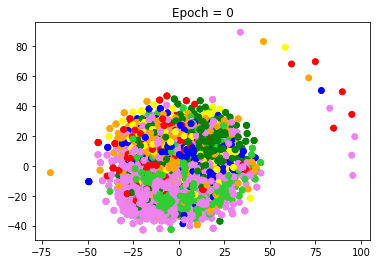

In [ ]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from google.colab import files

def tsne_plot(z,y,epoch):
  colors = []
  for i in range(len(z)):
    if y[i]==0:
      colors.append("orange");
    elif y[i]==1:
      colors.append("red");
    elif y[i]==2:
      colors.append("green");
    elif y[i]==3:
      colors.append("violet");
    elif y[i]==4:
      colors.append("limegreen");
    elif y[i]==5:
      colors.append("blue");
    elif y[i]==6:
      colors.append("yellow");

  tsne = TSNE(n_components=2, random_state=0, perplexity=10)
  tsne_results = tsne.fit_transform(z.detach().numpy())

  plt.figure(figsize=(6, 4))
  plt.scatter(tsne_results[:,0], tsne_results[:,1], c= colors)
  plt.title("Epoch = "+str(epoch))
  fname = str(epoch)+".png"
  plt.savefig(fname)
  # files.download(str(epoch)+".png") 
  images_dir = '/content/drive/MyDrive/Images'
  plt.savefig(f"{images_dir}/{fname}")

tsne_plot(dataset.x,dataset.y,0)

In [ ]:
def train(model, criterion, dataset, optimizer, epochs=100):
    i = 0
    loss_and_acc = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):        
          model.train()
          optimizer.zero_grad()
          z = model(dataset)
          x = z[dataset.train_mask]
          y = dataset.y[dataset.train_mask]
          # print(x.shape, y.shape)
          loss = criterion(x, y)          
          loss.backward()
          optimizer.step()
          loss_and_acc['training_loss'].append(loss.data.item())
          tsne_plot(z,dataset.y,epoch)
            
    correct = 0
    model.eval()
    z = model(dataset)
    valid_z = z[dataset.val_mask]
    valid_y = dataset.y[dataset.val_mask]
    _, label = torch.max(valid_z, 1)
    correct += (label == valid_y).sum().item()
    print(valid_y.shape, "\t", correct)  
    accuracy = 100 * (correct / len(valid_y))
    loss_and_acc['validation_accuracy'].append(accuracy)
    
    return loss_and_acc

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

torch.Size([500]) 	 382


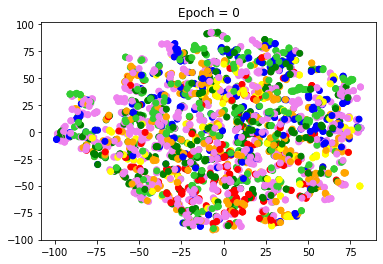

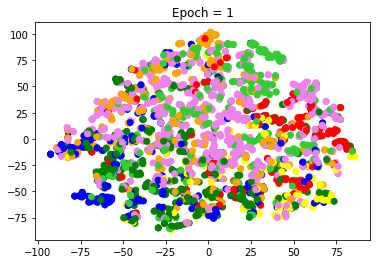

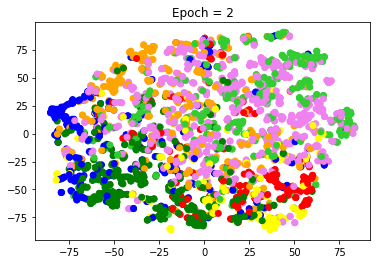

In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 200
learning_rate = 0.01
input_dim = dataset.num_node_features
hidden_dim = 16
output_dim = 7

model_norm  = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr=learning_rate, weight_decay = 5e-4)
training_results_Norm=train(model_norm, criterion, dataset, optimizer, epochs)

torch.Size([1000]) 	 800
80.0


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


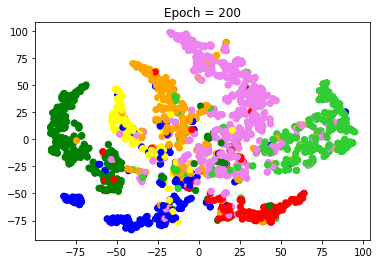

In [ ]:
PATH = "state_dict_model.pt" 
# torch.save(model_norm.state_dict(), PATH)

model = GCN(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load(PATH))

model.eval()
z = model(dataset)
test_z = z[dataset.test_mask]
test_y = dataset.y[dataset.test_mask]

correct = 0
_, label = torch.max(test_z, 1)
correct += (label == test_y).sum().item()
print(test_y.shape, "\t", correct)
test_acc = 100 * (correct / len(test_y))
print(test_acc)
tsne_plot(z, dataset.y, 200)

In [ ]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [ ]:
import os
import imageio

png_dir = '/content/drive/MyDrive/Images'
images = []
sorted_files =  sorted_alphanumeric(os.listdir(png_dir))
print(sorted_files)
for file_name in sorted_files:
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('/content/drive/MyDrive/Images/movie.gif', images, fps=1)


# from google.colab import files
#   uploaded = files.upload()
#   for k, v in uploaded.items():
#     open(k, 'wb').write(v)
#   return list(uploaded.keys())

['0.png', '10.png', '20.png', '30.png', '40.png', '50.png', '60.png', '70.png', '80.png', '90.png', '100.png', '110.png', '120.png', '130.png', '140.png', '150.png', '160.png', '170.png', '180.png', '190.png', '200.png', 'movie.gif']
